In [1]:
import sys
repo_path = '/home/micael.verissimo/paper_lzt/exp-connection-hep/'
sys.path.insert(0, repo_path)

In [2]:
import os
import numpy as np

from src.histograms_functions import (rebin_histogram, combine_edges, estimate_pdf_from_hist, 
                                      estimate_pds_over_same_support_from_hist, estimate_pdf_from_count_and_edges)
from src.exponential_connection import non_parametric_conection, calc_kl

Welcome to JupyROOT 6.30/02


2025-07-24 18:25:50.803180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-24 18:25:50.803237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-24 18:25:50.804123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-24 18:25:50.809066: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-24 18:25:52.633719: W tensorflow/compiler/tf2

In [3]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 10000

# Define the support range
x_min, x_max = -3, 3
x_support = np.linspace(x_min, x_max, 1000)

# 1. Gaussian distribution (mean=0, variance=1)
gaussian_samples = np.random.normal(loc=0, scale=1, size=n_samples)
gaussian_pdf = stats.norm.pdf(x_support, loc=0, scale=1)
g_counts, g_edges = np.histogram(gaussian_samples, bins=x_support, density=False)

# 2. Laplacian distribution (mean=10)
# For Laplacian, we'll use scale=1 by default
laplacian_samples = np.random.normal(loc=1, scale=1, size=n_samples) #np.random.laplace(loc=2, scale=1, size=n_samples)
laplacian_pdf = stats.norm.pdf(x_support, loc=1, scale=1)#stats.laplace.pdf(x_support, loc=2, scale=1)
l_counts, l_edges = np.histogram(laplacian_samples, bins=x_support, density=False)

# 3. Cauchy distribution (located in the middle between Gaussian and Laplacian)
# Middle point between 0 (Gaussian mean) and 2 (Laplacian mean) = 1
cauchy_samples = np.random.normal(loc=.5, scale=1, size=n_samples)#np.random.standard_cauchy(size=n_samples) + 1
cauchy_pdf = stats.norm.pdf(x_support, loc=.5, scale=1)#stats.cauchy.pdf(x_support, loc=1, scale=1)
c_counts, c_edges = np.histogram(cauchy_samples, bins=x_support, density=False)

print(f"Gaussian: mean={np.mean(gaussian_samples):.2f}, std={np.std(gaussian_samples):.2f}")
print(f"Laplacian: mean={np.mean(laplacian_samples):.2f}, std={np.std(laplacian_samples):.2f}")
print(f"Cauchy: median={np.median(cauchy_samples):.2f} (Cauchy mean is undefined)")

Gaussian: mean=-0.00, std=1.00
Laplacian: mean=1.01, std=1.00
Cauchy: median=0.49 (Cauchy mean is undefined)


In [4]:
# now we need to rebin the histograms to have the same support and a minimum of counts in each bin

n_g_counts, n_g_support = combine_edges(g_counts, g_edges, threshold=30)
n_l_counts, n_l_support = combine_edges(l_counts, l_edges, threshold=30)

g_pdf, l_pdf, new_support = estimate_pds_over_same_support_from_hist(
    n_g_counts, n_g_support, n_l_counts, n_l_support)



In [5]:
# move the cauchy to the same support
n_c_counts, n_c_support = combine_edges(c_counts, c_edges, threshold=30)
n_c_counts = rebin_histogram(n_c_support, n_c_counts, new_support)
c_pdf = estimate_pdf_from_count_and_edges(n_c_counts, new_support)

 [Thu, 24 Jul 2025 18:25:57] DEBUG Loaded backend module://matplotlib_inline.backend_inline version unknown.
 [Thu, 24 Jul 2025 18:25:57] DEBUG Loaded backend module://matplotlib_inline.backend_inline version unknown.
 [Thu, 24 Jul 2025 18:25:57] DEBUG Loaded backend module://matplotlib_inline.backend_inline version unknown.
 [Thu, 24 Jul 2025 18:25:57] DEBUG Loaded backend module://matplotlib_inline.backend_inline version unknown.
 [Thu, 24 Jul 2025 18:25:57] DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
 [Thu, 24 Jul 2025 18:25:57] DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
 [Thu, 24 Jul 2025 18:25:57] DEBUG findfont: score(FontEntry(fname='/home/micael.verissimo/envs/root-env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.3

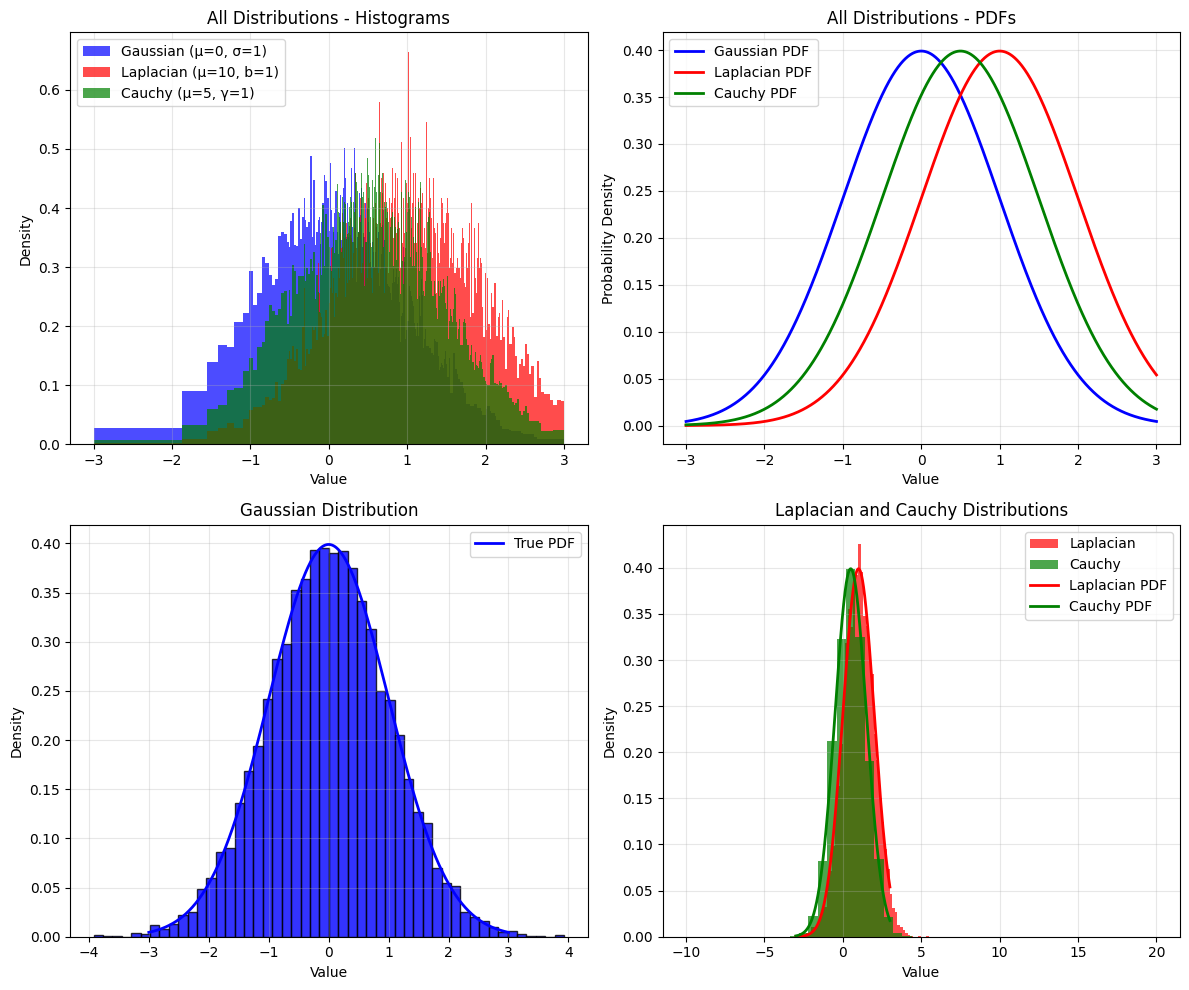

In [6]:
# Create histograms and plot PDFs
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: All histograms together
axes[0, 0].hist(new_support[:-1], new_support, weights=g_pdf, alpha=0.7, label='Gaussian (μ=0, σ=1)', color='blue')
axes[0, 0].hist(new_support[:-1], new_support, weights=l_pdf, alpha=0.7, label='Laplacian (μ=10, b=1)', color='red')
axes[0, 0].hist(new_support[:-1], new_support, weights=c_pdf, alpha=0.7, label='Cauchy (μ=5, γ=1)', color='green', range=(-10, 20))
axes[0, 0].set_title('All Distributions - Histograms')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: All PDFs together
axes[0, 1].plot(x_support, gaussian_pdf, label='Gaussian PDF', color='blue', linewidth=2)
axes[0, 1].plot(x_support, laplacian_pdf, label='Laplacian PDF', color='red', linewidth=2)
axes[0, 1].plot(x_support, cauchy_pdf, label='Cauchy PDF', color='green', linewidth=2)
axes[0, 1].set_title('All Distributions - PDFs')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Probability Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Individual histograms
axes[1, 0].hist(gaussian_samples, bins=50, alpha=0.8, density=True, color='blue', edgecolor='black')
axes[1, 0].plot(x_support, gaussian_pdf, 'blue', linewidth=2, label='True PDF')
axes[1, 0].set_title('Gaussian Distribution')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Laplacian and Cauchy together
axes[1, 1].hist(laplacian_samples, bins=50, alpha=0.7, density=True, color='red', label='Laplacian')
axes[1, 1].hist(cauchy_samples, bins=50, alpha=0.7, density=True, color='green', label='Cauchy', range=(-10, 20))
axes[1, 1].plot(x_support, laplacian_pdf, 'red', linewidth=2, label='Laplacian PDF')
axes[1, 1].plot(x_support, cauchy_pdf, 'green', linewidth=2, label='Cauchy PDF')
axes[1, 1].set_title('Laplacian and Cauchy Distributions')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
exp_connection = non_parametric_conection(n_params=100, pdf1=g_pdf, pdf2=l_pdf, support=new_support)

2025-07-24 18:25:58.639 | INFO     | src.exponential_connection:__init__:48 - Exponential connection created with 100 points.
2025-07-24 18:25:58.640 | INFO     | src.exponential_connection:__init__:49 - Minimum KL divergence value (excluding diagonal): 5.056403929e-05


In [8]:
kl_val, best_t, kl_values, angles = exp_connection.get_nearest_point(c_pdf)

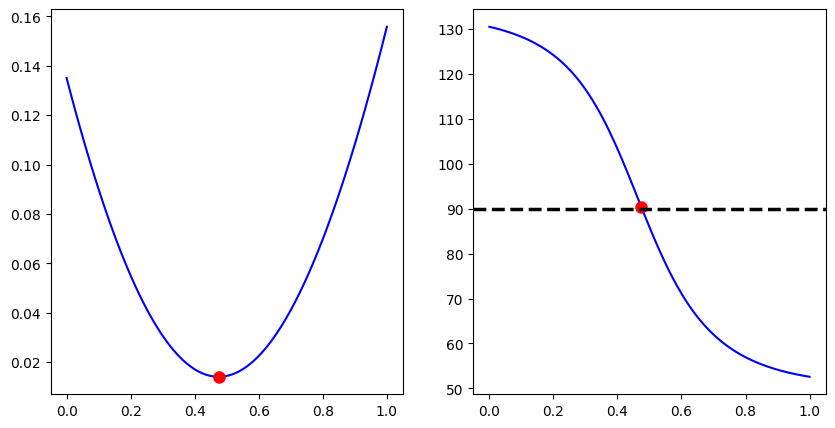

In [9]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

ax1.plot(exp_connection.t_params, kl_values, label='KL Divergence', color='blue')
ax1.plot(exp_connection.t_params[best_t], kl_val, 'ro', label='Minimum KL Divergence', markersize=8)

ax2.plot(exp_connection.t_params, angles, label='Angle Projection', color='blue')
ax2.plot(exp_connection.t_params[best_t], angles[best_t], 'ro', label='Best Angle Projection', markersize=8)
ax2.axhline(90, color='black', linestyle='--', linewidth=2.5)

 [Thu, 24 Jul 2025 18:25:59] DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0.
 [Thu, 24 Jul 2025 18:25:59] DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0.
 [Thu, 24 Jul 2025 18:25:59] DEBUG findfont: score(FontEntry(fname='/home/micael.verissimo/envs/root-env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
 [Thu, 24 Jul 2025 18:25:59] DEBUG findfont: score(FontEntry(fname='/home/micael.verissimo/envs/root-env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
 [Thu, 24 Jul 2025 18:25:59] DEBUG findfont: score(FontEntry(fname='/home/micael.verissimo/envs/root-env/lib/python3.11/site-packages/

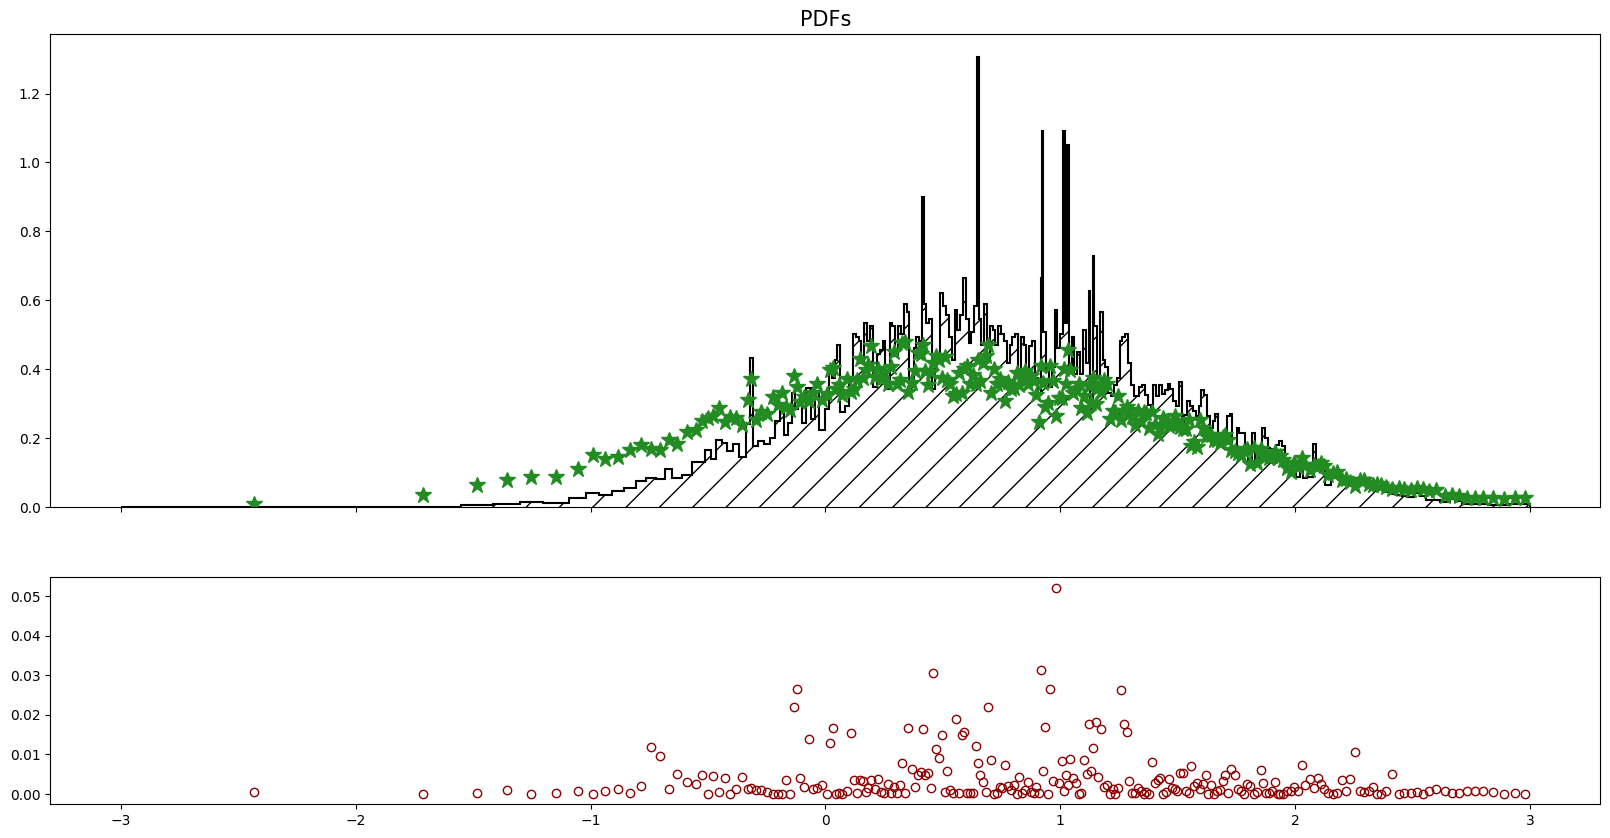

In [10]:
#def create_projection_comp_plot(pdf1, proj_pdf1, pdf2, proj_pdf2, exp_connection):
bin_width = np.array(np.diff(exp_connection.support), float)
fig, axis = plt.subplots(nrows=2, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios' : [2.5, 1.2]})

(ax1, ax2) = axis.flatten()
#-------------------------------------
# plot using cutbased manifold
ax1.set_title(r'PDFs', fontsize=15)
x_axis = exp_connection.support[0: -1] + np.diff(exp_connection.support)/2

ax1.hist(exp_connection.support[:-1],
         exp_connection.support,
         weights=c_pdf, 
         histtype='step', hatch='/', color='black', density=True, lw=1.5, label=r'Cauchy PDF')

ax1.plot(x_axis, exp_connection.exp_connection[best_t], '*', lw=1., ms=12, color='forestgreen', label=r'Cauchy Proj Best match in $p_{exp}(x| t=$%1.4f)' %best_t)
ax2.plot(x_axis, calc_kl(c_pdf, exp_connection.exp_connection[best_t]), 
         'o', color='darkred', fillstyle='none', label=r'$D_{KL}[$Cauchy $: p_{exp}(x| t=$%1.3f)]' %(best_t))



In [11]:
exp_connection.t_params[best_t]


0.4747474747474748